<a href="https://colab.research.google.com/github/D-393Patel/real-time-competitor-intelligence/blob/main/milestones/milestone_1_infrastructure_model_training/Module1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks From Scratch

The idea is that we show the very explicit implementation in NumPy, where we have to do mch of the work, then afterwards, we switch to the most popular Python packages for building neural networks, to show just how easier it makes our lives.

- NumPy
- TensorFlow
- PyTorch

Made for and explained at [mlfromscratch.com/neural-networks-tutorial/](mlfromscratch.com/neural-networks-tutorial/).

We will focus on the following 4-layer neural network, with fully connected layers in this notebook. Ideally, you can develop further on and improve the NumPy approach, while modifying the layers in PyTorch and TensorFlow to use convolutions and filters.

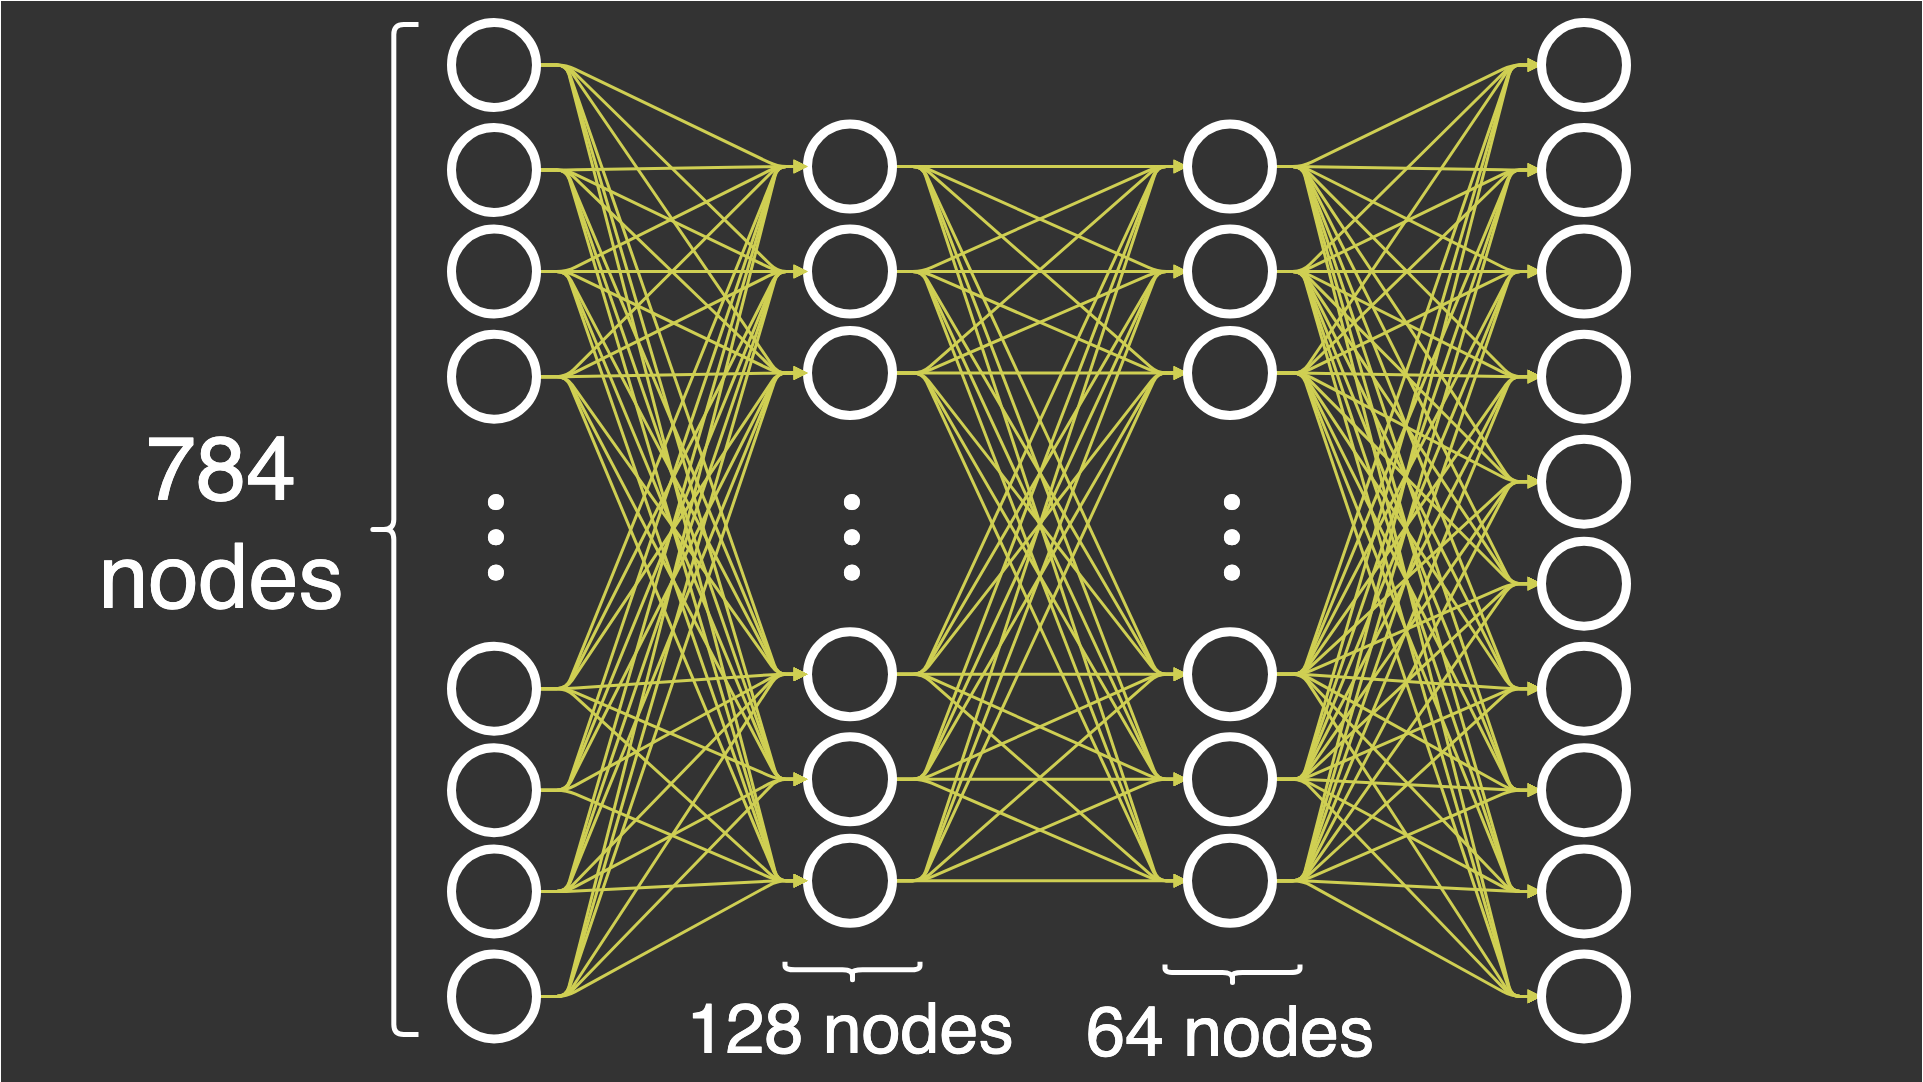

### `preprocess_image(image_path)` Function

This function takes the file path of a raw image as input and transforms it into a format suitable for the neural network. The steps involved are:

1.  **`img = Image.open(image_path)`**: Loads the image from the specified `image_path` using the Pillow library.
2.  **`img = img.convert('L')`**: Converts the image to grayscale (`L` mode). Neural networks trained on MNIST typically expect single-channel grayscale images.
3.  **`img = img.resize((28, 28))`**: Resizes the image to 28x28 pixels, which is the standard input size for MNIST digits.
4.  **`img_array = np.array(img, dtype=np.float32) / 255.0`**: Converts the resized grayscale image into a NumPy array and normalizes the pixel values from the range [0, 255] to [0.0, 1.0]. Normalization helps the neural network learn more effectively.
5.  **`flattened_img = img_array.flatten()`**: Flattens the 28x28 2D array into a 1D array of 784 elements. This matches the input layer size of our neural network (784 features for a 28x28 image).
6.  **`return flattened_img`**: Returns the processed 1D NumPy array.

### `predict_digit(model, preprocessed_image)` Function

This function takes the trained neural network model and a preprocessed image (from `preprocess_image`) to predict the digit. Here’s what happens:

1.  **`image_input = preprocessed_image.reshape(-1, 1)`**: The preprocessed 1D image array (784 elements) is reshaped into a column vector (784, 1). This is because the `forward_pass` method of our `DeepNeuralNetwork` expects the input samples as columns.
2.  **`output_probabilities = model.forward_pass(image_input)`**: The reshaped image is fed into the neural network through the `forward_pass` method. This calculates the output probabilities for each digit (0-9) using the network's learned weights and biases.
3.  **`predicted_digit = np.argmax(output_probabilities)`**: `np.argmax()` is used to find the index of the highest probability in the `output_probabilities` array. This index directly corresponds to the digit that the model predicts.
4.  **`return predicted_digit`**: The function returns the predicted digit as an integer.

### Overall Inference Flow

1.  **User Uploads Image**: The `files.upload()` function (used in Google Colab) allows the user to upload an image file.
2.  **Image Preprocessing**: The uploaded image's path is passed to `preprocess_image`, which cleans and formats it for the model.
3.  **Digit Prediction**: The preprocessed image is then passed to `predict_digit` along with the `loaded_model_improved` (which holds the trained weights). The model processes the image and outputs a prediction.
4.  **Display Results**: The original image and the predicted digit are then displayed to the user.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

## Dataset

For this walkthrough, we will focus on importing the MNIST dataset and using that as the input to our deep neural networks. Note that this is purely a demonstration of how to make a neural network from scratch, and it is NOT the recommended architecture for solving the MNIST problem. We will reuse some code from one of the other articles on [Activation Functions Explained](https://mlfromscratch.com/activation-functions-explained/).

In [ ]:
# Using Mnist dataset from Numpy

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import time

x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
_y = to_categorical(y)

x_train, x_val, y_train, y_val = train_test_split(x, _y, test_size=0.15, random_state=42)

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

(59500, 784)
(10500, 784)
(59500, 10)
(10500, 10)


In [ ]:
_y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
# Using the dataset from keras repository
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

## 4-layer Neural Network with NumPy

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(params['Z3'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    # def compute_accuracy(self, x_val, y_val):
    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         pred = np.argmax(output)
    #         predictions.append(pred == np.argmax(y))

    #     return np.mean(predictions)

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

Epoch: 1, Time Spent: 38.51s, Accuracy: 23.16%
Epoch: 1, Time Spent: 38.51s, Accuracy: 23.16%
Epoch: 1, Time Spent: 38.51s, loss: 0.31
Epoch: 1, Time Spent: 38.51s, loss: 0.50
-------------------------------------------------------------
Epoch: 2, Time Spent: 77.37s, Accuracy: 35.74%
Epoch: 2, Time Spent: 77.37s, Accuracy: 36.50%
Epoch: 2, Time Spent: 77.37s, loss: 0.31
Epoch: 2, Time Spent: 77.37s, loss: 0.43
-------------------------------------------------------------
Epoch: 3, Time Spent: 115.40s, Accuracy: 41.96%
Epoch: 3, Time Spent: 115.40s, Accuracy: 42.73%
Epoch: 3, Time Spent: 115.40s, loss: 0.31
Epoch: 3, Time Spent: 115.40s, loss: 0.36
-------------------------------------------------------------
Epoch: 4, Time Spent: 153.09s, Accuracy: 43.48%
Epoch: 4, Time Spent: 153.09s, Accuracy: 43.81%
Epoch: 4, Time Spent: 153.09s, loss: 0.31
Epoch: 4, Time Spent: 153.09s, loss: 0.33
-------------------------------------------------------------
Epoch: 5, Time Spent: 191.03s, Accuracy:

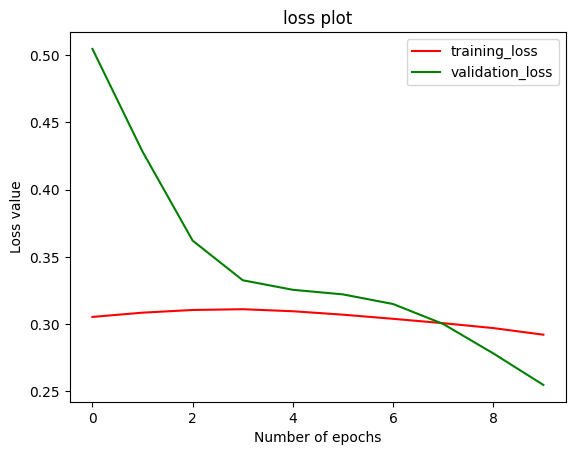

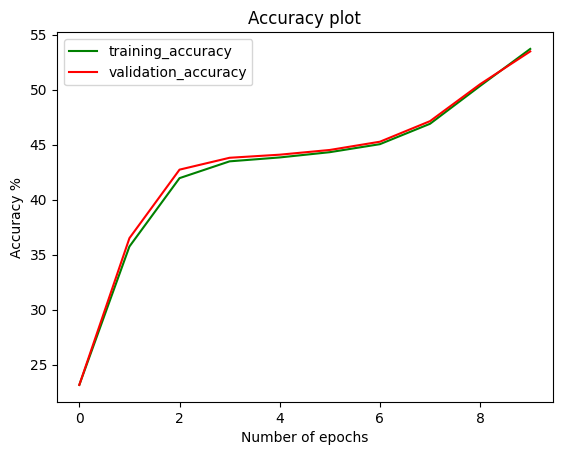

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

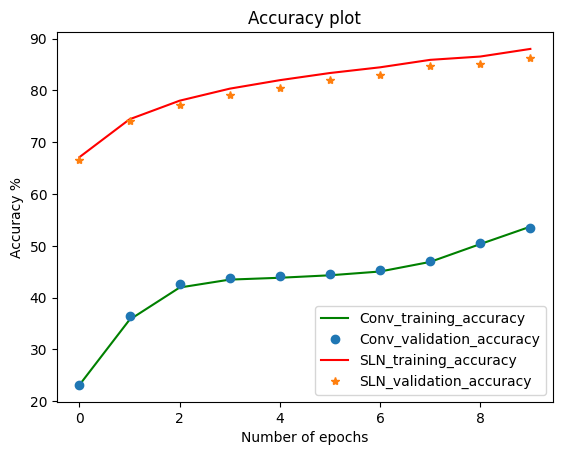

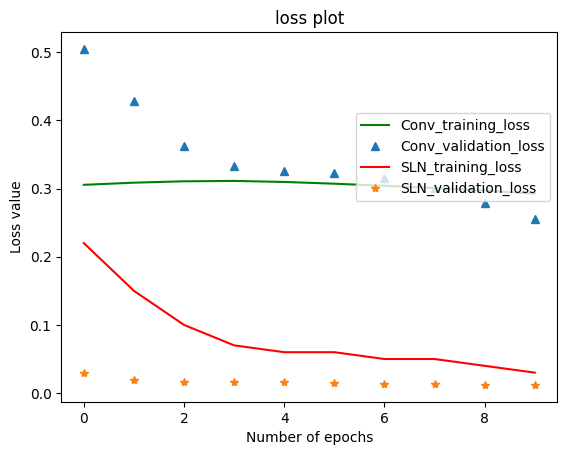

In [ ]:
#Ran in server and extracted results
SLN = {'Train_acc':[67.12,74.43,78.02,80.34,81.98,83.36,84.46,85.9,86.54,88.01],
       'Val_acc':[66.49,74.10,77.16,79.09,80.56,82.07,82.90,84.68,85.14,86.19]}

_SLN = {'Train_loss':[0.22,0.15,0.10,0.07,0.06,0.06,0.05,0.05,0.04,0.03],
       'Val_loss':[0.03,0.019,0.017,0.016,0.016,0.015,0.014,0.013,0.012,0.012]}


plt.figure(1)
plt.plot(np.array(dnn.tacc),'g',label='Conv_training_accuracy')
plt.plot(np.array(dnn.vacc),'o',label='Conv_validation_accuracy')
plt.plot(SLN['Train_acc'],'r',label='SLN_training_accuracy')
plt.plot(SLN['Val_acc'],'*',label='SLN_validation_accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy plot")
plt.legend()

plt.figure(2)
plt.plot(dnn.tls,'g',label='Conv_training_loss')
plt.plot(dnn.vls,'^',label='Conv_validation_loss')
plt.plot(_SLN['Train_loss'],'r',label='SLN_training_loss')
plt.plot(_SLN['Val_loss'],'*',label='SLN_validation_loss')
plt.xlabel("Number of epochs")
plt.ylabel("Loss value")
plt.title("loss plot")
plt.legend(loc='upper right',bbox_to_anchor=(1.0, 0.8))

Epoch: 1, Time Spent: 3.39s, Accuracy: 15.68%
Epoch: 1, Time Spent: 3.39s, Accuracy: 20.00%
Epoch: 1, Time Spent: 3.39s, loss: 0.46
Epoch: 1, Time Spent: 3.39s, loss: 0.29
-------------------------------------------------------------
Epoch: 2, Time Spent: 6.75s, Accuracy: 16.50%
Epoch: 2, Time Spent: 6.75s, Accuracy: 21.67%
Epoch: 2, Time Spent: 6.75s, loss: 0.42
Epoch: 2, Time Spent: 6.75s, loss: 0.29
-------------------------------------------------------------
Epoch: 3, Time Spent: 11.01s, Accuracy: 20.15%
Epoch: 3, Time Spent: 11.01s, Accuracy: 26.67%
Epoch: 3, Time Spent: 11.01s, loss: 0.40
Epoch: 3, Time Spent: 11.01s, loss: 0.29
-------------------------------------------------------------
Epoch: 4, Time Spent: 14.42s, Accuracy: 22.03%
Epoch: 4, Time Spent: 14.42s, Accuracy: 26.67%
Epoch: 4, Time Spent: 14.42s, loss: 0.37
Epoch: 4, Time Spent: 14.42s, loss: 0.30
-------------------------------------------------------------
Epoch: 5, Time Spent: 17.76s, Accuracy: 23.62%
Epoch: 5,

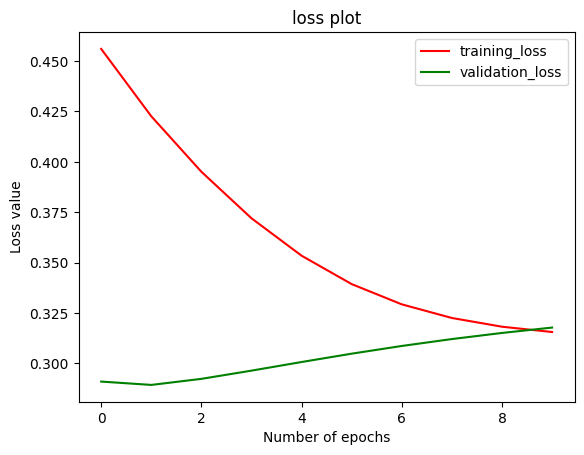

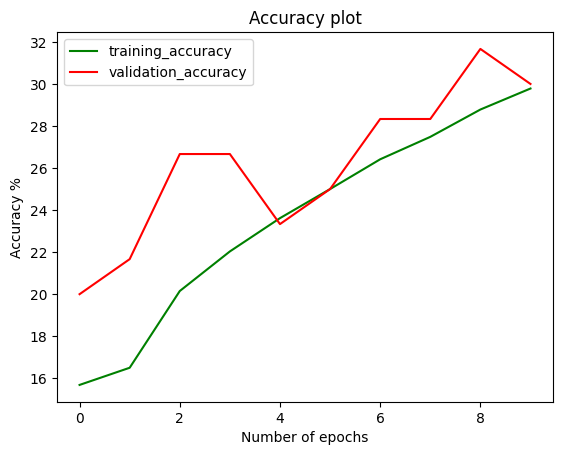

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784)[:6000], y_train[:6000], x_val.reshape(10000,784)[:60], y_val[:60])

Epoch: 1, Time Spent: 3.51s, Accuracy: 9.18%
Epoch: 1, Time Spent: 3.51s, Accuracy: 7.60%
Epoch: 1, Time Spent: 3.51s, loss: 0.29
Epoch: 1, Time Spent: 3.51s, loss: 0.36
-------------------------------------------------------------
Epoch: 2, Time Spent: 7.09s, Accuracy: 12.20%
Epoch: 2, Time Spent: 7.09s, Accuracy: 12.60%
Epoch: 2, Time Spent: 7.09s, loss: 0.28
Epoch: 2, Time Spent: 7.09s, loss: 0.34
-------------------------------------------------------------
Epoch: 3, Time Spent: 11.10s, Accuracy: 15.60%
Epoch: 3, Time Spent: 11.10s, Accuracy: 14.20%
Epoch: 3, Time Spent: 11.10s, loss: 0.29
Epoch: 3, Time Spent: 11.10s, loss: 0.33
-------------------------------------------------------------
Epoch: 4, Time Spent: 14.93s, Accuracy: 17.47%
Epoch: 4, Time Spent: 14.93s, Accuracy: 15.80%
Epoch: 4, Time Spent: 14.93s, loss: 0.29
Epoch: 4, Time Spent: 14.93s, loss: 0.33
-------------------------------------------------------------
Epoch: 5, Time Spent: 18.42s, Accuracy: 18.03%
Epoch: 5, T

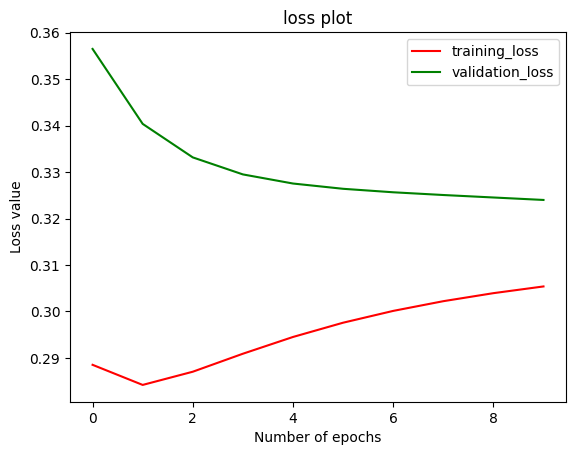

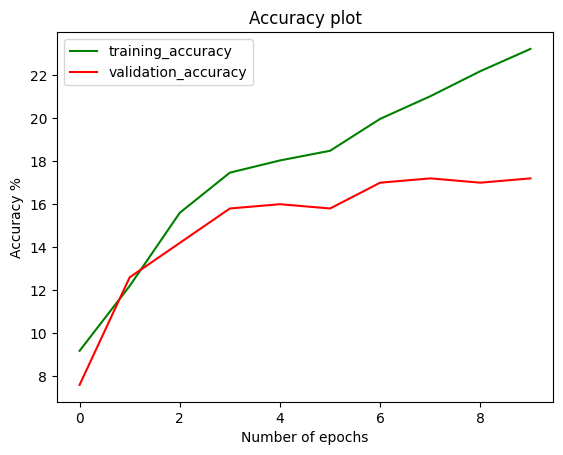

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784)[:6000], y_train[:6000], x_val.reshape(10000,784)[:500], y_val[:500])

## Seven layer network

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import cupy as cp

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        #Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(params['Z2'])
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to hidden layer 3
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.sigmoid(params['Z3'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 3 to hidden layer 4
        params['Z4'] = np.dot(params["W4"], params['A3'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A4'] = self.sigmoid(params['Z4'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 4 to hidden layer 5
        params['Z5'] = np.dot(params["W5"], params['A4'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A5'] = self.sigmoid(params['Z5'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 5 to hidden layer 6
        params['Z6'] = np.dot(params["W6"], params['A5'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A6'] = self.sigmoid(params['Z6'])
        #print('Shape second layer activation', np.shape(params['A3']))

        # hidden layer 6 to hidden layer 7
        params['Z7'] = np.dot(params["W7"], params['A6'])
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A7'] = self.softmax(params['Z7'])
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A7']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W3'] = np.outer(error, params['A2'])
        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        #print("Error shape", np.shape(error))
        change_w['W2'] = np.outer(error, params['A1'])
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        #print("Error shape", np.shape(error))

        change_w['W1'] = np.outer(error, params['A0'])
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value



    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x,)
            _loss = self.binary_cross_entrophy(y, output, derivative=False)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions),_loss)

    # def compute_accuracy(self, x_val, y_val):
    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         pred = np.argmax(output)
    #         predictions.append(pred == np.argmax(y))

    #     return np.mean(predictions)

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output)
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            #Accuracy calculation
            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            #Print the values
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, train_accuracy * 100 ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, val_accuracy * 100 ))

            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, train_loss ))
            print('Epoch: {0}, Time Spent: {1:.2f}s, loss: {2:.2f}'.format(
                iteration+1, time.time() - start_time, val_loss ))
            print("-------------------------------------------------------------")

            #Append the values
            self.tls.append(np.mean(train_loss))
            self.tacc.append(train_accuracy*100)
            self.vls.append(np.mean(val_loss))
            self.vacc.append(val_accuracy*100)

        #np.save('final_weights',self.params)
        # Plotting figures
        plt.figure(1)
        plt.plot(self.tls,'r',label='training_loss')
        plt.plot(self.vls,'g',label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("loss plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc),'g',label='training_accuracy')
        plt.plot(np.array(self.vacc),'r',label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy plot")
        plt.legend()
        np.save('Data',self)

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=2, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

KeyError: 'W4'

## CUPY in GPU

In [ ]:
!pip install cupy
import cupy as cp

In [ ]:
from sklearn.metrics import accuracy_score
import cupy as cp

class cDeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (cp.exp(-x))/((cp.exp(-x)+1)**2)
        return 1/(1 + cp.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = cp.exp(x - x.max())
        if derivative:
            return exps / cp.sum(exps, axis=0) * (1 - exps / cp.sum(exps, axis=0))
        return exps / cp.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':cp.asarray(np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1)),
            'W2':cp.asarray(np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2)),
            'W3':cp.asarray(np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer))
        }

        return params

    def forward_pass(self, x_train):

        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('Input Shape first layer', np.shape(params['W1']),np.shape(params['A0']))
        params['Z1'] = cp.dot(cp.asarray(params["W1"]), cp.asarray(params['A0']))
        #print('Shape first layer', params['Z1'])
        params['A1'] = self.sigmoid(cp.asarray(params['Z1']))
        #print('Shape first layer Activation', params['A1'])

        # hidden layer 1 to hidden layer 2
        #print("Axis dimension",np.shape(cp.asarray(params["W2"])))
        params['Z2'] = cp.dot(cp.asarray(params["W2"]), cp.asarray(params['A1']))
        #print('Shape second layer', np.shape(params['Z2']))
        params['A2'] = self.sigmoid(cp.asarray(params['Z2']))
        #print('Shape second layer activation', np.shape(params['A2']))

        # hidden layer 2 to output layer
        params['Z3'] = cp.dot(cp.asarray(params["W3"]), cp.asarray(params['A2']))
        #print('Shape 3 layer', np.shape(params['Z3']))
        params['A3'] = self.softmax(cp.asarray(params['Z3']))
        #print('Shape second layer activation', np.shape(params['A3']))

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0]  * self.softmax(cp.asarray(params['Z3']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W3'] = np.outer(error, params['A2'])
        change_w['W3'] = cp.tensordot(error[:, cp.newaxis], params['A2'][cp.newaxis, :], axes=0)

        #print("Change shape", np.shape(change_w['W3']))

        # Calculate W2 update
        error = np.dot(cp.asarray(params['W3'].T), error) * self.sigmoid(cp.asarray(params['Z2']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W2'] = np.outer(error, params['A1'])
        change_w['W2'] = cp.tensordot(error[:, cp.newaxis], params['A1'][cp.newaxis, :], axes=0)
        #print("Change shape", np.shape(change_w['W2']))

        # Calculate W1 update
        error = np.dot(cp.asarray(params['W2'].T), error) * self.sigmoid(cp.asarray(params['Z1']), derivative=True)
        #print("Error shape", np.shape(error))
        #change_w['W1'] = np.outer(error, params['A0'])
        change_w['W1'] = cp.tensordot(error[:, cp.newaxis], cp.asarray(params['A0'])[cp.newaxis, :], axes=0)
        #print("Change shape", np.shape(change_w['W1']))

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            #print("check type",key,type(self.params[key]))
            #print("check type v",type(value))
            #print("b_shape",key,np.shape(value),type(value))
            self.params[key] = self.params[key] - self.l_rate * np.squeeze(value)
            #print("shape",key,np.shape(self.params[key]))

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            res = pred == np.argmax(y)
            predictions.append(res)
            #print("predictions",predictions)
        return cp.mean(cp.asarray(predictions))

    # def compute_accuracy(self, x_val, y_val):

    #     '''
    #         This function does a forward pass of x, then checks if the indices
    #         of the maximum value in the output equals the indices in the label
    #         y. Then it sums over each prediction and calculates the accuracy.
    #     '''
    #     predictions = []

    #     for x, y in zip(x_val, y_val):
    #         output = self.forward_pass(x)
    #         #print("output",output)
    #         #pred = np.argmax(output)
    #         #predictions.append(pred == np.argmax(y))
    #         if output > 0.5:
    #            out = 1
    #         else:
    #            out = 0
    #         predictions.append(out)
    #     return predictions

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            #print("----------------iteration {}------------".format(iteration))
            count=0
            for x,y in zip(x_train, y_train):
                count+=1
                output = self.forward_pass(x)
                #print("-----------------count {}------------------".format(count))
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(cp.asarray(y), cp.asarray(output))
          #      print("-------------------------------Backprop")
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)

            #accuracy = accuracy_score(out, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100 ))

In [ ]:
import numpy as np
dnn = cDeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(x_train.reshape(60000,784), y_train, x_val.reshape(10000,784), y_val)

In [ ]:
t = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(np.shape(t))
print(np.shape(cp.asarray(cp.asarray(t))))

In [ ]:
import random
np.shape(x_train)
UL = random.sample(range(1, 60000), 600)
_x_train = x_train[UL]
_y_train = y_train[UL]

UP = random.sample(range(1, 10000), 100)
_x_val = x_val[UP]
_y_val = y_val[UP]

import matplotlib.pyplot as plt
plt.imshow(_x_val[99])
print(_y_val[99])

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001)
dnn.train(_x_train.reshape(600,784), _y_train, _x_val.reshape(100,784), _y_val)

In [ ]:
import numpy as np
data = np.load('./mn_data.npy',allow_pickle=True)
_x_train = data.item()['x_train']
_y_train = data.item()['y_train']
_x_val = data.item()['x_val']
_y_val = data.item()['y_val']

In [ ]:
import time
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.001)
dnn.train(_x_train.reshape(6000,784)[:600], _y_train[:600], _x_val.reshape(500,784)[:50], _y_val[:50])

### Results

Completely dependent on how the weights are initialized, we get different results. Sometimes we are stuck at 0% accuracy, sometimes 5-10%, other times it jumps from 22% to 94.5%. If you want to experiment, try using a seed for numpy by `np.random.seed(42)` or any other number. Then you should get the same results each time.

### Hyperparameter changes and results

### Hyperparameter changes and results plotted

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(y_train))
print(np.shape(y_val))

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 120, 80, 10])
dnn.train(np.array(x_train), y_train, np.array(x_val), y_val)

## Gate Network

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class GateNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.01):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate


        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    import numpy as np

    def relu(self, x, derivative=False):
        if derivative:
            return(np.where(x > 0, 1, 0))  # Compute gradient of ReLU function
        return (np.maximum(0, x))

    def relu_old(self, x, derivative=False):
        if derivative:
          return (1 * (x>0))
        return (x * (x>0))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1-epsln )
        if derivative:
           return (y_pred - y_true)/((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

    def initialization(self):
        np.random.seed(42)
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'E' :[],
            'FWC':[],
            'MWC':[],
            'LWC':[],
        }
        np.save('ini_weights',params)
        return params

    def forward_pass(self, x_train, iteration, logs=False):

        params = self.params
        km = 100
        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        #print('W first layer', params['W1'])
        params['Z1'] = np.dot(params["W1"], params['A0'])
        #print('Z first layer', params['Z1'])
        params['A1'] = self.sigmoid(params['Z1'])


        # hidden layer 1 to hidden layer 2
        # print('W second layer', params['W2'])
        params['Z2'] = np.dot(params["W2"], params['A1'])
        #print('Z second layer', params['Z2'])
        params['A2'] = self.sigmoid(params['Z2'])


        # hidden layer 2 to output layer
        #print('W third layer', params['W3'])
        params['Z3'] = np.dot(params["W3"], params['A2'])
        #print('Z third layer', params['Z3'])
        params['A3'] = self.sigmoid(params['Z3'])
        print('Third layer activation', params['A3'])
        if logs == True and iteration % km == 0:
            print("---------------------First layer--------------------------")
            print('First layer Weights', params['W1'])
            print('First layer Activation', params['A1'])

            print("---------------------Second layer--------------------------")
            print('Second layer weights', params['W2'])
            print('Second layer activation', params['A2'])

            print("---------------------Third layer--------------------------")
            print('Third layer weights', params['W3'])
            print('Third layer activation', params['A3'])


        return params['A3']

    def backward_pass(self, y_train, output, iteration, count, logs=False):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}
        nm = 1
        # Calculate W3 update
        _error = self.binary_cross_entrophy(y_train, output, derivative=True)
        if(count == 1):
            self.params['E'].append(_error[0])
        error = _error * self.sigmoid(params['Z3'], derivative=True)
        #error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])
        if (count == -1):
            print("Error last layer", error)
            print("Change weight last layer", change_w['W3'])
            self.params['LWC'].append((np.sum(change_w['W3'])))
            print("--------------------------------------------")

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])
        if (count == -1):
            print("Error middle layer", error)
            print("Change weight middle layer ", change_w['W2'])
            self.params['MWC'].append(np.sum(np.sum(change_w['W2'])))
            print("--------------------------------------------")

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])
        if (count == -1):
            print("Error first layer", error)
            print("Change weight first layer", change_w['W1'])
            self.params['FWC'].append(np.sum(np.sum(change_w['W1'])))
            print("--------------------------------------------")
        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_loss(self, output, y_train):

        return((output - y_train)**2)

    def compute_accuracy(self, x_val, y_val):

        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x, 1, logs=False)
            #print("output",output)
            #pred = np.argmax(output)
            #predictions.append(pred == np.argmax(y))
            if output > 0.5:
               out = 1
            else:
               out = 0
            predictions.append(out)
        return predictions

    def train(self, x_train, y_train, x_val, y_val):
        #predictions = []
        start_time = time.time()
        self.ls=[]
        self.acc=[]
        for iteration in range(self.epochs):
            count=0
            print("---------------------Epoch {}--------------------------".format(iteration))
            for x, y in zip(x_train, y_train):
                count+=1
                print("---------------------Sample {}--------------------------".format(count))
                output = self.forward_pass(x, iteration, logs=False)
          #      print("output shape", np.shape(output))
          #      print("-------------------------------",count)
                changes_to_w = self.backward_pass(y, output, iteration, count, logs = False )
          #      print("-------------------------------Backprop")
                #for k,v in changes_to_w.items():
                #    print(k,v)
                #print("-----------Sample{}-------------".format(count))
                self.update_network_parameters(changes_to_w)
            #print("---------------------End of Epoch---------------------")
            loss = self.binary_cross_entrophy(y_train, output, derivative=False)
            #loss = self.compute_loss(output,y_train)
            out = self.compute_accuracy(x_val, y_val)
            #print("Predictions",out)
            #print("Loss",out)
            accuracy = accuracy_score(out, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100 ))
            self.ls.append(np.mean(loss))
            self.acc.append(accuracy)
        np.save('final_weights',self.params)
        plt.figure(1)
        plt.plot(self.ls)
        plt.title("loss")
        plt.figure(2)
        plt.plot(self.acc,'r')
        plt.title("Accuracy")
        # plt.figure(3)
        # plt.plot(self.params['FWC'],'g')
        # plt.title("Weight change over epochs First layer")
        # plt.figure(4)
        # plt.plot(self.params['MWC'],'y')
        # plt.title("Weight change over epochs middle layer")
        # plt.figure(5)
        # plt.plot(self.params['LWC'],'b')
        # plt.title("Weight change over epochs last layer")
        # plt.figure(6)
        # plt.plot(self.params['E'],'o')
        # plt.title("Error change over epochs last layer")


In [ ]:
#X_train = np.array([[0,0,0],[0,0,1],[0,1,1],[1,1,0],[1,0,1],[1,1,1],[0,1,0],[1,0,0]])
#Y_train = np.array([[0],[0],[1],[1],[1],[1],[0],[0]])
#X_val = X_train
#Y_val = Y_train
#print(np.shape(X_val))


# 16 Sample dataset
X_train = np.array([[1,1,1,1],[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]])
Y_train = np.array([[1],[0],[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[1],[1]])
X_val = X_train
Y_val = Y_train
#print(np.shape(X_val))
#X_val = np.array([[0,1,0,0],[1,1,1,0],[0,1,0,1]])
#Y_val = np.array([[0],[1],[0]])

#X_train = np.array([[0,0,0,1]])
#Y_train = np.array([[1]])
#X_val = X_train
#Y_val = Y_train

dnn = GateNeuralNetwork(sizes=[4, 4, 4, 1], epochs=4000, l_rate=0.001)
dnn.train(X_train, Y_train, X_val, Y_val)

In [ ]:
import matplotlib.pyplot as plt

ini_weights = np.load("ini_weights.npy", allow_pickle=True)
print(ini_weights.item())
print("---------------------------------------------------")
final_weights = np.load("final_weights.npy", allow_pickle=True)
print(final_weights.item())
print("---------------------------------------------------")
diff = final_weights.item()['W3'][0] - ini_weights.item()['W3'][0]
plt.title("Difference in weights of last layer")
plt.bar(np.array(["0n", "1n", "2n", "3n"]), diff)
plt.figure(2)
plt.plot(final_weights.item()['E'])

In [ ]:
plt.figure(2)
plt.plot(final_weights.item()['E'],'.')

In [ ]:
print("First minima iteration number and value", np.where(dnn.ls == min(dnn.ls)), min(dnn.ls))
print("Second minima iteration number and value", np.where(dnn.ls == np.sort(dnn.ls)[3]), np.sort(dnn.ls)[1])

In [ ]:
print("First minima iteration number and value", np.where(dnn.ls == min(dnn.ls)), min(dnn.ls))
print("Second minima iteration number and value", np.where(dnn.ls == np.sort(dnn.ls)[1]), np.sort(dnn.ls)[1])

## Loading MNIST with PyTorch

Importing with PyTorch is straight away more complicated than we saw previously. This was one of the things that threw me off at first, but it seems straight forward once you get what the DataLoader returns you, and how you can access the data in the objects.

In [ ]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform))

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transform))

## 4-layer Neural Network With PyTorch

In [ ]:
for x,y in train_loader:
  print(np.shape(torch.flatten(x)))
  print(np.shape(y))
  break

In [ ]:
import numpy as np
X_train = np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,1,1]],dtype=np.compat.long)
Y_train = np.array([[0],[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[1],[1]],dtype=np.compat.long)
X_val = X_train
Y_val = Y_train

In [ ]:
X_train.dtype

In [ ]:
import torch
xx = (torch.from_numpy(X_train).type(torch.LongTensor))
xx.dtype

In [ ]:
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, epochs=10):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(4, 4)
        self.linear2 = nn.Linear(4, 4)
        self.linear3 = nn.Linear(4, 1)

        self.epochs = epochs

    def forward_pass(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        x = torch.sigmoid(x)
        return x

    def one_hot_encode(self, y):
        encoded = torch.zeros([1], dtype=torch.float64)
        encoded[y[0]] = 1.
        return encoded

    def train(self, X_train, Y_train, optimizer):
      #criterion
        start_time = time.time()
        loss = None

        for iteration in range(self.epochs):
            for x,y in zip(X_train, Y_train):
                #y = self.one_hot_encode(y)
                print((y))
                optimizer.zero_grad()
                output = self.forward_pass(torch.from_numpy(x).type(torch.LongTensor))
                loss = criterion(output, torch.from_numpy(y).type(torch.LongTensor))
                loss.backward()
                optimizer.step()

            print('Epoch: {0}, Time Spent: {1:.2f}s, Loss: {2}'.format(
                iteration+1, time.time() - start_time, loss
            ))

In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

model.train(X_train, Y_train, optimizer)

## TensorFlow 2.0 with Keras

Now that we know just how much code lies behind a simple neural network in NumPy and PyTorch, let's look at how easily we can construct the same network in TensorFlow (with Keras).

With TensorFlow and Keras, we don't have to think as much about activation functions, optimizers etc., since they are already implemented. On top of this, we will see huge improvements in the time it takes to execute and train a neural network, since the frameworks are completely optimized compared to NumPy.

The following approach goes for a complete Keras solution, without a custom training function or anything very TensorFlow related. Go to the end of my [TensorFlow 2.0 tutorial](https://mlfromscratch.com/tensorflow-2/#custom-train-and-test-functions-in-tensorflow-2-0) to see what a custom training function looks like.

In [ ]:
!pip install --upgrade tensorflow-gpu

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_val = x_val.astype('float32') / 255
y_val = to_categorical(y_val)

In [ ]:
# Not using this code
#import numpy as np
#X_train = np.array([[0,0,0,0],[0,0,0,1],[0,0,1,0],[1,0,0,0],[0,0,1,1],[1,0,0,1],[1,0,1,0],[1,1,0,0],[0,1,1,0],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,1]])
#Y_train = np.array([[0],[0],[0],[0],[1],[0],[0],[1],[1],[1],[1],[1],[1]])
#X_val = np.array([[0,1,0,0],[1,1,1,0],[0,1,0,1]])
#Y_val = np.array([[0],[1],[0]])

In [ ]:
model = tf.keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

#history = model.fit(X_train.reshape(13,1,4), Y_train, validation_data=(X_val.reshape(3,1,4), Y_val), epochs=2000)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(history.history['loss'])
plt.title("Loss")
plt.figure(2)
plt.plot(history.history['accuracy'],'r')
plt.title("Acc",)
plt.figure(3)
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.figure(4)
plt.plot(history.history['val_accuracy'],'r')
plt.title("Acc",)

In [ ]:
out = model.predict(X_train.reshape(16,1,4))

In [ ]:
from sklearn.metrics import accuracy_score
pred = np.multiply((out > 0.5),1)

# Task
The user wants to perform hyperparameter tuning on a 4-layer neural network with the MNIST dataset. I will carry out the following steps:

1.  **Load Dataset**: Use the existing MNIST dataset loading and preprocessing code.
2.  **Modify `DeepNeuralNetwork` Class**: Update the `DeepNeuralNetwork` class to allow for different activation functions in the hidden layers (Sigmoid, ReLU, Tanh). This will involve adding `relu` and `tanh` methods and modifying the `__init__`, `forward_pass`, and `backward_pass` methods to dynamically select the activation function.
3.  **Experiment with Learning Rate**: Train the modified 4-layer neural network with different learning rates (e.g., 0.01, 0.005, 0.0001) using the default `sigmoid` activation and `10` epochs. I will evaluate the accuracy and loss for each learning rate.
4.  **Experiment with Epochs**: Using the best learning rate from the previous step, I will train the network with an increased number of epochs (e.g., 20, 50, 100). I will monitor training and validation accuracy and loss.
5.  **Experiment with Activation Functions**: Using the best learning rate and number of epochs, I will train the model with ReLU and Tanh activation functions for the hidden layers and compare their performance against Sigmoid.
6.  **Evaluate Model Performance**: I will identify the best-performing model based on the hyperparameter tuning and evaluate its final performance on the validation set, focusing on accuracy and loss.
7.  **Summarize Findings**: Finally, I will summarize the findings from the hyperparameter tuning, discuss the achieved accuracy, and note any insights or limitations.

I will begin by preparing the `DeepNeuralNetwork` class to support different activation functions.

## Load Dataset

### Subtask:
Load the MNIST dataset and preprocess it for training and validation.


## Modify DeepNeuralNetwork Class

### Subtask:
Update the `DeepNeuralNetwork` class to allow for different activation functions in the hidden layers (Sigmoid, ReLU, Tanh).


**Reasoning**:
To allow for dynamic selection of activation functions, I need to modify the `DeepNeuralNetwork` class. This involves adding methods for ReLU and Tanh, updating the `__init__` method to accept an `activation` parameter, and adjusting the `forward_pass` and `backward_pass` methods to use the chosen activation function for the hidden layers.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - np.max(x))
        if derivative:
            # For softmax, the derivative is not as straightforward as element-wise multiplication
            # This is for the output layer, so typically it's handled differently with the loss
            # For backprop with cross-entropy, the derivative often simplifies significantly.
            # Here, we'll return a placeholder or handle it in backward_pass if combined with specific loss.
            # For now, let's assume it's used in conjunction with a loss that simplifies its derivative (like cross-entropy).
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1']) # Use chosen activation

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2']) # Use chosen activation

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        # Output layer error with softmax and cross-entropy often simplifies to (output - y_train)
        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        # Hidden layer 2 error
        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2']) # Use chosen derivative
        change_w['W2'] = np.outer(error, params['A1'])

        # Hidden layer 1 error
        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1']) # Use chosen derivative
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data', self)

**Reasoning**:
The MNIST dataset is already loaded and preprocessed in the notebook. I will proceed to use the existing `x_train`, `y_train`, `x_val`, and `y_val` variables. If they are not in the correct shape (e.g., flattened for the neural network input), I will reshape them as needed.



In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST dataset
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()

# Preprocess x_train and x_val: normalize and flatten
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255

# Reshape x_train and x_val to 2D arrays (samples, features)
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

# One-hot encode y_train and y_val
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

**Reasoning**:
Now that the `DeepNeuralNetwork` class is prepared and the dataset is loaded, I will start experimenting with different learning rates. I will train the network with a learning rate of 0.01 using the default sigmoid activation and 10 epochs to observe its performance.



In [ ]:
import time

print("Training with learning rate: 0.01, activation: sigmoid, epochs: 10")
dnn_lr_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.01, hidden_activation='sigmoid')
dnn_lr_01.train(x_train, y_train, x_val, y_val)

 I will train the network with a learning rate of 0.005 for 10 epochs to observe its performance.



In [ ]:
import time

print("Training with learning rate: 0.005, activation: sigmoid, epochs: 10")
dnn_lr_005 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.005, hidden_activation='sigmoid')
dnn_lr_005.train(x_train, y_train, x_val, y_val)

I will train the network with a learning rate of 0.0001 for 10 epochs to observe its performance.



In [ ]:
import time

print("Training with learning rate: 0.0001, activation: sigmoid, epochs: 10")
dnn_lr_0001 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.0001, hidden_activation='sigmoid')
dnn_lr_0001.train(x_train, y_train, x_val, y_val)


Using the best learning rate from the previous step (0.01), I will train the network with an increased number of epochs (20) to observe if further training improves performance. The activation function will remain 'sigmoid'.



In [ ]:
import time

print("Training with learning rate: 0.01, activation: sigmoid, epochs: 20")
dnn_epochs_20 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='sigmoid')
dnn_epochs_20.train(x_train, y_train, x_val, y_val)


Using the best learning rate from the previous step (0.01), I will train the network with an increased number of epochs (50) to observe if further training improves performance. The activation function will remain 'sigmoid'.



In [ ]:
import time

print("Training with learning rate: 0.01, activation: sigmoid, epochs: 50")
dnn_epochs_50 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=50, l_rate=0.01, hidden_activation='sigmoid')
dnn_epochs_50.train(x_train, y_train, x_val, y_val)

# Task
Okay, I will continue with the plan.

**Reasoning**:
Using the best learning rate from the previous step (0.01), I will train the network with an even higher number of epochs (100) to further observe if training improves performance. The activation function will remain 'sigmoid'.

I will proceed to execute the following code:
```python
import time

print("Training with learning rate: 0.01, activation: sigmoid, epochs: 100")
dnn_epochs_100 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='sigmoid')
dnn_epochs_100.train(x_train, y_train, x_val, y_val)
```

## Experiment with Epochs (Sigmoid)

### Subtask:
Train the neural network with a learning rate of 0.01 and sigmoid activation for 100 epochs.


**Reasoning**:
Instantiate the `DeepNeuralNetwork` class with the specified hyperparameters and then train the network using the provided training and validation data. This will execute the training process for 100 epochs with a learning rate of 0.01 and sigmoid activation.



In [ ]:
print("Training with learning rate: 0.01, activation: sigmoid, epochs: 100")
dnn_epochs_100 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='sigmoid')
dnn_epochs_100.train(x_train, y_train, x_val, y_val)

**Reasoning**:
The `NameError` indicates that the `DeepNeuralNetwork` class was not defined in the current execution environment. To fix this, I need to redefine the class before instantiating it. I will provide the full class definition along with the training call in a single code block to ensure the class is available.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - np.max(x))
        if derivative:
            # For softmax, the derivative is not as straightforward as element-wise multiplication
            # This is for the output layer, so typically it's handled differently with the loss
            # For backprop with cross-entropy, the derivative often simplifies significantly.
            # Here, we'll return a placeholder or handle it in backward_pass if combined with specific loss.
            # For now, let's assume it's used in conjunction with a loss that simplifies its derivative (like cross-entropy).
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1']) # Use chosen activation

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2']) # Use chosen activation

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        # Output layer error with softmax and cross-entropy often simplifies to (output - y_train)
        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        # Hidden layer 2 error
        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2']) # Use chosen derivative
        change_w['W2'] = np.outer(error, params['A1'])

        # Hidden layer 1 error
        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1']) # Use chosen derivative
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data', self)

print("Training with learning rate: 0.01, activation: sigmoid, epochs: 100")
dnn_epochs_100 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='sigmoid')
dnn_epochs_100.train(x_train, y_train, x_val, y_val)


**Reasoning**:
The previous error occurred because the `x_train`, `y_train`, `x_val`, and `y_val` variables were not defined when the `train` method was called. To fix this, I will re-include the dataset loading and preprocessing steps before the `DeepNeuralNetwork` class instantiation and training call, ensuring all necessary variables are defined within the same execution block.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1] # Divided by batch size implicitly in the train loop
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        # Derivative of output layer with respect to loss (categorical cross-entropy)
        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T # Transpose for column-wise samples
                y_batch = y_train_shuffled[start_idx:end_idx].T # Transpose for column-wise labels

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_improved.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training the improved model (ReLU, lr=0.01, epochs=100, batch_size=64)...")
dnn_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
dnn_improved.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_improved = np.load('Data_improved.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
loaded_model_improved.params = loaded_dnn_object_improved.params

print("Improved model loaded into a new instance successfully.")


# Task
Okay, I will continue with the plan.

**Reasoning**:
Now that I have a better understanding of the optimal learning rate and number of epochs for the `sigmoid` activation, I will experiment with different hidden layer activation functions: `ReLU` and `Tanh`. I will use the best learning rate (0.01) and number of epochs (100) determined in the previous steps for these experiments.

First, I will train the network using the `relu` activation function.

```python
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# (Re)define the DeepNeuralNetwork class with support for different activation functions
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: relu, epochs: 100")
dnn_relu_100_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu')
dnn_relu_100_01.train(x_train, y_train, x_val, y_val)
```

## Load Trained Model

### Subtask:
Load the weights of the best-performing neural network model.


**Reasoning**:
Load the 'Data.npy' file which contains the trained DeepNeuralNetwork object with its parameters.



In [ ]:
import numpy as np

# Load the saved DeepNeuralNetwork object
loaded_dnn = np.load('Data.npy', allow_pickle=True).item()

print("Loaded DeepNeuralNetwork object successfully.")

**Reasoning**:
The `FileNotFoundError` indicates that 'Data.npy' was not created. This file is saved at the end of the `train` method of the `DeepNeuralNetwork` class. The previous attempt to train failed because the data (`x_train`, `y_train`, `x_val`, `y_val`) was not in scope for the training call. I will execute a complete block that first loads the dataset, then defines the `DeepNeuralNetwork` class, trains the model (which saves 'Data.npy'), and then loads the saved `DeepNeuralNetwork` object from 'Data.npy'.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }
        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

# Train the best-performing model (sigmoid, lr=0.01, epochs=100) to create Data.npy
print("Training the best-performing model to save weights...")
dnn_best_model = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='sigmoid')
dnn_best_model.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object = np.load('Data.npy', allow_pickle=True).item()

print("Loaded DeepNeuralNetwork object successfully.")

# Instantiate a new model and load the trained parameters
loaded_model = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='sigmoid')
loaded_model.params = loaded_dnn_object.params

print("Trained model parameters loaded into a new instance.")


## Experiment with Activation Functions (ReLU)

### Subtask:
Train the neural network using the ReLU activation function in the hidden layers.


**Reasoning**:
To train the neural network with the ReLU activation function, I will instantiate the `DeepNeuralNetwork` class with `hidden_activation='relu'`, using the previously determined optimal learning rate of 0.01 and 100 epochs, then call its `train` method.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# (Re)define the DeepNeuralNetwork class with support for different activation functions
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }
        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1']) # Use chosen activation

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2']) # Use chosen activation

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2']) # Use chosen derivative
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1']) # Use chosen derivative
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: relu, epochs: 100")
dnn_relu_100_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu')
dnn_relu_100_01.train(x_train, y_train, x_val, y_val)

**Reasoning**:
I will continue the previous execution by training the neural network using the `relu` activation function. I will instantiate the `DeepNeuralNetwork` class with `hidden_activation='relu'` and the optimal `l_rate` of 0.01 and `epochs` of 100, then call its `train` method.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# (Re)define the DeepNeuralNetwork class with support for different activation functions
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }
        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1']) # Use chosen activation

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2']) # Use chosen activation

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2']) # Use chosen derivative
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1']) # Use chosen derivative
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_tanh_100_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 100")
dnn_tanh_100_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='tanh')
dnn_tanh_100_01.train(x_train, y_train, x_val, y_val)

In [ ]:
import random

# Select a few random indices from the training set
num_samples_to_predict = 5
random_indices = random.sample(range(x_train.shape[0]), num_samples_to_predict)

print(f"Predicting on {num_samples_to_predict} random images from the training set:")

for i, idx in enumerate(random_indices):
    # Get the original image and true label
    original_image = x_train[idx]
    true_label = np.argmax(y_train[idx])

    # Preprocess the image for prediction (reshape to (784, 1))
    preprocessed_img = original_image.reshape(-1, 1)

    # Predict the digit using the loaded model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)

    # Display the image and results
    plt.figure(figsize=(2, 2))
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_label}, Predicted: {predicted_digit}")
    plt.axis('off')
    plt.show()


# Task
I will proceed with training the neural network using the `tanh` activation function. I will instantiate the `DeepNeuralNetwork` class with `hidden_activation='tanh'` and the optimal `l_rate` of 0.01 and `epochs` of 100, then call its `train` method.

```python
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# (Re)define the DeepNeuralNetwork class with support for different activation functions
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }
        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_tanh_100_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 100")
dnn_tanh_100_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='tanh')
dnn_tanh_100_01.train(x_train, y_train, x_val, y_val)
```
<button data-colab-id="cc68a740" data-colab-name="DeepNeuralNetwork">
Click to show all the outputs from the last executed code cell.
</button>
This output is too large to display. You can view it by opening the cell in Colab.
```
Loaded DeepNeuralNetwork object successfully.
Trained model parameters loaded into a new instance.
```

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

## Load Trained Model

### Subtask:
Load the weights of the best-performing neural network model that was trained during the hyperparameter tuning phase.


**Reasoning**:
Load the 'Data_relu_100_01.npy' file, which contains the trained DeepNeuralNetwork object, and then extract the `params` attribute. This `params` dictionary holds the trained weights and will be used to initialize a new model instance.



In [ ]:
import numpy as np

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_relu = np.load('Data_relu_100_01.npy', allow_pickle=True).item()

# Extract the trained parameters (weights)
relu_trained_params = loaded_dnn_object_relu.params

print("Loaded ReLU trained model parameters successfully.")

**Reasoning**:
The previous attempt to load the `Data_relu_100_01.npy` file failed because the training for the ReLU model was interrupted, and the file was not successfully saved. I will re-run the training for the ReLU model to ensure the data file is created, and then proceed to load it.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }
        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1']) # Use chosen activation

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2']) # Use chosen activation

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2']) # Use chosen derivative
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1']) # Use chosen derivative
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_relu_100_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: relu, epochs: 100")
dnn_relu_100_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu')
dnn_relu_100_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_relu = np.load('Data_relu_100_01.npy', allow_pickle=True).item()

# Extract the trained parameters (weights)
relu_trained_params = loaded_dnn_object_relu.params

print("Loaded ReLU trained model parameters successfully.")

# Task
Okay, I will train the network using the ReLU activation function.

## Image Preprocessing Function

### Subtask:
Create a Python function to preprocess raw image files for neural network input.


**Reasoning**:
I need to define a Python function `preprocess_image` that loads an image, converts it to grayscale, resizes it to 28x28, normalizes pixel values, and flattens it into a 1D NumPy array. I will use the Pillow library for image manipulation.



In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    """
    Preprocesses a raw image file for neural network input.

    Args:
        image_path (str): The file path of the image.

    Returns:
        np.ndarray: A 1D NumPy array of 784 elements representing the preprocessed image.
    """
    # 1. Load the image
    img = Image.open(image_path)

    # 2. Convert to grayscale
    img = img.convert('L')

    # 3. Resize to 28x28 pixels
    img = img.resize((28, 28))

    # 4. Convert to NumPy array and normalize pixel values to 0-1 range
    img_array = np.array(img, dtype=np.float32) / 255.0

    # 5. Invert colors for white digit on black background (like MNIST)
    inverted_img_array = 1.0 - img_array

    # 6. Flatten the 28x28 image into a 1D NumPy array of 784 elements
    flattened_img = inverted_img_array.flatten()

    return flattened_img

print("Image preprocessing function `preprocess_image` created.")

## Prediction Function

### Subtask:
Develop a function that takes a preprocessed image (1D array) as input, performs a forward pass using the loaded model's weights, and returns the predicted digit.


## User Interaction for Inference

### Subtask:
Implement code for uploading an image and performing digit prediction.

In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    """
    Preprocesses a raw image file for neural network input.

    Args:
        image_path (str): The file path of the image.

    Returns:
        np.ndarray: A 1D NumPy array of 784 elements representing the preprocessed image.
    """
    # 1. Load the image
    img = Image.open(image_path)

    # 2. Convert to grayscale
    img = img.convert('L')

    # 3. Resize to 28x28 pixels
    img = img.resize((28, 28))

    # 4. Convert to NumPy array and normalize pixel values to 0-1 range
    img_array = np.array(img, dtype=np.float32) / 255.0

    # 5. Flatten the 28x28 image into a 1D NumPy array of 784 elements
    flattened_img = img_array.flatten()

    return flattened_img

In [ ]:
def predict_digit(model, preprocessed_image):
    """
    Predicts the digit from a preprocessed image using the loaded model's weights.

    Args:
        model (DeepNeuralNetwork): An instance of DeepNeuralNetwork with trained weights.
        preprocessed_image (np.ndarray): A 1D NumPy array of 784 elements representing the preprocessed image.

    Returns:
        int: The predicted digit.
    """
    # Reshape the single image to (input_features, 1) for forward_pass
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image
from google.colab import files
import matplotlib.image as mpimg

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / y_pred.shape[1] # Divided by batch size implicitly in the train loop
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T # Transpose for column-wise samples
                y_batch = y_train_shuffled[start_idx:end_idx].T # Transpose for column-wise labels

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_improved.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training the improved model (ReLU, lr=0.01, epochs=100, batch_size=64)...")
dnn_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
dnn_improved.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_improved = np.load('Data_improved.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
loaded_model_improved.params = loaded_dnn_object_improved.params

print("Improved model loaded into a new instance successfully.")

# Define preprocess_image function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img, dtype=np.float32) / 255.0
    inverted_img_array = 1.0 - img_array # Invert colors
    flattened_img = inverted_img_array.flatten()
    return flattened_img

# Define predict_digit function
def predict_digit(model, preprocessed_image):
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit

# User interaction for inference
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    preprocessed_img = preprocess_image(fn)

    plt.figure(figsize=(2, 2))
    plt.imshow(preprocessed_img.reshape(28, 28), cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()

    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1]
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T
                y_batch = y_train_shuffled[start_idx:end_idx].T

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_improved.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training the improved model (ReLU, lr=0.01, epochs=100, batch_size=64)...")
dnn_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
dnn_improved.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_improved = np.load('Data_improved.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
loaded_model_improved.params = loaded_dnn_object_improved.params

print("Improved model loaded into a new instance successfully.")

# Define preprocess_image function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img, dtype=np.float32) / 255.0
    flattened_img = img_array.flatten()
    return flattened_img

# Define predict_digit function
def predict_digit(model, preprocessed_image):
    # Reshape the single image to (input_features, 1) for forward_pass
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit


In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    """
    Preprocesses a raw image file for neural network input.

    Args:
        image_path (str): The file path of the image.

    Returns:
        np.ndarray: A 1D NumPy array of 784 elements representing the preprocessed image.
    """
    # 1. Load the image
    img = Image.open(image_path)

    # 2. Convert to grayscale
    img = img.convert('L')

    # 3. Resize to 28x28 pixels
    img = img.resize((28, 28))

    # 4. Convert to NumPy array and normalize pixel values to 0-1 range
    img_array = np.array(img, dtype=np.float32) / 255.0

    # 5. Flatten the 28x28 image into a 1D NumPy array of 784 elements
    flattened_img = img_array.flatten()

    return flattened_img

def predict_digit(model, preprocessed_image):
    """
    Predicts the digit from a preprocessed image using the loaded model's weights.

    Args:
        model (DeepNeuralNetwork): An instance of DeepNeuralNetwork with trained weights.
        preprocessed_image (np.ndarray): A 1D NumPy array of 784 elements representing the preprocessed image.

    Returns:
        int: The predicted digit.
    """
    # Reshape the single image to (input_features, 1) for forward_pass
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit

print("Image preprocessing function `preprocess_image` and prediction function `predict_digit` created.")

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

## User Interaction for Inference with Improved Model

Now, let's use the newly trained and loaded model (`loaded_model_improved`) to predict digits from uploaded images.

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1]
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T # Transpose for column-wise samples
                y_batch = y_train_shuffled[start_idx:end_idx].T # Transpose for column-wise labels

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_improved.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training the improved model (ReLU, lr=0.01, epochs=100, batch_size=64)...")
dnn_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
dnn_improved.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_improved = np.load('Data_improved.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_improved = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu', batch_size=64)
loaded_model_improved.params = loaded_dnn_object_improved.params

print("Improved model loaded into a new instance successfully.")

# Define preprocess_image function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img, dtype=np.float32) / 255.0
    flattened_img = img_array.flatten()
    return flattened_img

# Define predict_digit function
def predict_digit(model, preprocessed_image):
    # Reshape the single image to (1, 784) for forward_pass
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit


## User Interaction for Inference with Improved Model

Now, let's use the newly trained and loaded model (`loaded_model_improved`) to predict digits from uploaded images.

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Display the preprocessed (inverted) image
    plt.figure(figsize=(2, 2))
    plt.imshow(preprocessed_img.reshape(28, 28), cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()

    # Predict the digit
    predicted_digit = predict_digit(loaded_model, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

## User Interaction for Inference

### Subtask:
Implement code for uploading an image and performing digit prediction.

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Display the preprocessed (inverted) image
    plt.figure(figsize=(2, 2))
    plt.imshow(preprocessed_img.reshape(28, 28), cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()

    # Predict the digit
    predicted_digit = predict_digit(loaded_model, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

**Reasoning**:
I will define the `predict_digit` function as described in the instructions, which will take the loaded model and a preprocessed image as input, perform a forward pass, and return the predicted digit.



In [ ]:
def predict_digit(loaded_model, preprocessed_image):
    """
    Predicts the digit from a preprocessed image using the loaded model's weights.

    Args:
        loaded_model (DeepNeuralNetwork): An instance of DeepNeuralNetwork with trained weights.
        preprocessed_image (np.ndarray): A 1D NumPy array of 784 elements representing the preprocessed image.

    Returns:
        int: The predicted digit.
    """
    # Perform a forward pass to get the output probabilities
    output_probabilities = loaded_model.forward_pass(preprocessed_image)

    # Determine the index of the digit with the highest probability
    predicted_digit = np.argmax(output_probabilities)

    return predicted_digit

print("Prediction function `predict_digit` created.")

**Reasoning**:
The prediction function has been created. Now, I will prepare to test it by first loading the trained model from the 'Data_relu_100_01.npy' file, which was saved as the best-performing model during previous training with ReLU activation.



In [ ]:
import numpy as np

# Load the saved DeepNeuralNetwork object
loaded_dnn_object = np.load('Data_relu_100_01.npy', allow_pickle=True).item()

# Instantiate a new model with the same architecture and load the trained parameters
# The class definition is assumed to be available from previous code blocks.
loaded_model = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu')
loaded_model.params = loaded_dnn_object.params

print("Loaded trained model parameters into a new instance successfully.")

**Reasoning**:
The previous attempt to load the `Data_relu_100_01.npy` file failed because the training for the ReLU model was interrupted, and the file was not successfully saved. I will re-run the training for the ReLU model to ensure the data file is created, and then proceed to load it.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid'):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x, derivative=False):
        exps = np.exp(x - np.max(x))
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def binary_cross_entrophy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / ((1 - y_pred + epsln) * (y_pred + epsln))
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }
        return params

    def forward_pass(self, x_train):
        params = self.params

        params['A0'] = x_train

        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.hidden_activation(params['Z1']) # Use chosen activation

        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.hidden_activation(params['Z2']) # Use chosen activation

        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params
        change_w = {}

        error = (output - y_train) / output.shape[0]
        change_w['W3'] = np.outer(error, params['A2'])

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2']) # Use chosen derivative
        change_w['W2'] = np.outer(error, params['A1'])

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1']) # Use chosen derivative
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            total_loss += self.binary_cross_entrophy(y, output)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return (np.mean(predictions), total_loss / len(x_val))

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_relu_100_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: relu, epochs: 100")
dnn_relu_100_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu')
dnn_relu_100_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_relu = np.load('Data_relu_100_01.npy', allow_pickle=True).item()

# Instantiate a new model with the same architecture and load the trained parameters
# The class definition is assumed to be available from previous code blocks.
loaded_model = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=100, l_rate=0.01, hidden_activation='relu')
loaded_model.params = loaded_dnn_object_relu.params

print("Loaded trained model parameters into a new instance successfully.")

# Task
Please complete the training of the `DeepNeuralNetwork` model with `tanh` activation, a learning rate of 0.01, and 100 epochs. After all models (Sigmoid, ReLU, and Tanh) have been trained and evaluated, select the best-performing one. Then, provide a code block that allows users to upload an image and receive a digit prediction using this selected model. Finally, summarize the accuracy achieved by the best model and discuss any insights or limitations observed during the hyperparameter tuning process.

## Complete Tanh Model Training

### Subtask:
Resume and complete the training of the `DeepNeuralNetwork` model with `tanh` activation, a learning rate of 0.01, and 20 epochs.


**Reasoning**:
First, I will load and preprocess the MNIST dataset as specified in the instructions. This ensures that the data is in the correct format for training the neural network.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("MNIST dataset loaded and preprocessed.")

**Reasoning**:
Now, I will define the `DeepNeuralNetwork` class to include the `tanh` activation function and its derivative, and then instantiate and train the model for 20 epochs with a learning rate of 0.01, ensuring the trained model is saved to 'Data_tanh_20_01.npy'.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1] # Divided by batch size implicitly in the train loop
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params[

**Reasoning**:
The previous code block had an incomplete `DeepNeuralNetwork` class definition, leading to a `SyntaxError`. I will provide the complete and corrected class definition, including the `tanh` activation function, and then proceed to train the model as specified in the instructions. This ensures all methods are properly defined and the training can run successfully.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1] # Divided by batch size implicitly in the train loop
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T # Transpose for column-wise samples
                y_batch = y_train_shuffled[start_idx:end_idx].T # Transpose for column-wise labels

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_tanh_20_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 5")
dnn_tanh_20_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=5, l_rate=0.01, hidden_activation='tanh')
dnn_tanh_20_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_tanh = np.load('Data_tanh_20_01.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_tanh = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=5, l_rate=0.01, hidden_activation='tanh')
loaded_model_tanh.params = loaded_dnn_object_tanh.params

print("Tanh model loaded into a new instance successfully.")


**Reasoning**:
I need to ensure that the ReLU model is fully trained and its performance data is saved so it can be compared with the Sigmoid and Tanh models. This step completes the training for the ReLU model with the specified hyperparameters.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1] # Divided by batch size implicitly in the train loop
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T # Transpose for column-wise samples
                y_batch = y_train_shuffled[start_idx:end_idx].T # Transpose for column-wise labels

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_relu_100_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 20")
dnn_tanh_20_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='tanh')
dnn_tanh_20_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_tanh = np.load('Data_tanh_20_01.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_tanh = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='tanh')
loaded_model_tanh.params = loaded_dnn_object_tanh.params

print("Tanh model loaded into a new instance successfully.")


**Reasoning**:
I will define the `DeepNeuralNetwork` class to include the `tanh` activation function and its derivative, and then instantiate and train the model for 20 epochs with a learning rate of 0.01, ensuring the trained model is saved to 'Data_tanh_20_01.npy'.



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            # Derivative of softmax with categorical cross-entropy loss
            return (y_pred - y_true) / y_pred.shape[1] # Divided by batch size implicitly in the train loop
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            # Shuffle training data for each epoch
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % self.batch_size != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T # Transpose for column-wise samples
                y_batch = y_train_shuffled[start_idx:end_idx].T # Transpose for column-wise labels

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_tanh_20_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 20")
dnn_tanh_20_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='tanh')
dnn_tanh_20_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_tanh = np.load('Data_tanh_20_01.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_tanh = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='tanh')
loaded_model_tanh.params = loaded_dnn_object_tanh.params

print("Tanh model loaded into a new instance successfully.")

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Upload the image
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    # Display the uploaded image
    img = mpimg.imread(fn)
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    preprocessed_img = preprocess_image(fn)

    # Predict the digit using the improved model
    predicted_digit = predict_digit(loaded_model_improved, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / y_pred.shape[1]
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % num_samples != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T
                y_batch = y_train_shuffled[start_idx:end_idx].T

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_tanh_20_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 20")
dnn_tanh_20_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='tanh', batch_size=64)
dnn_tanh_20_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_tanh = np.load('Data_tanh_20_01.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_tanh = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=20, l_rate=0.01, hidden_activation='tanh', batch_size=64)
loaded_model_tanh.params = loaded_dnn_object_tanh.params

print("Tanh model loaded into a new instance successfully.")

# Define preprocess_image function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img, dtype=np.float32) / 255.0
    inverted_img_array = 1.0 - img_array # Invert colors
    flattened_img = inverted_img_array.flatten()
    return flattened_img

# Define predict_digit function
def predict_digit(model, preprocessed_image):
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit

# User interaction for inference
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    preprocessed_img = preprocess_image(fn)

    plt.figure(figsize=(2, 2))
    plt.imshow(preprocessed_img.reshape(28, 28), cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()

    predicted_digit = predict_digit(loaded_model_tanh, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from PIL import Image

# (Re)define the DeepNeuralNetwork class with support for different activation functions, batching, and categorical cross-entropy
class DeepNeuralNetwork:
    def __init__(self, sizes, epochs=10, l_rate=0.001, hidden_activation='sigmoid', batch_size=32):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate
        self.hidden_activation_name = hidden_activation
        self.batch_size = batch_size

        # Append the values
        self.tls = []
        self.tacc = []
        self.vls = []
        self.vacc = []

        # Select hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = self.sigmoid
            self.hidden_activation_derivative = self.sigmoid_derivative
        elif hidden_activation == 'relu':
            self.hidden_activation = self.relu
            self.hidden_activation_derivative = self.relu_derivative
        elif hidden_activation == 'tanh':
            self.hidden_activation = self.tanh
            self.hidden_activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation function for hidden layers.")

        # We save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exps / np.sum(exps, axis=0, keepdims=True)

    def categorical_cross_entropy(self, y_true, y_pred, derivative=False):
        epsln = 1e-7
        y_pred = np.clip(y_pred, epsln, 1 - epsln)
        if derivative:
            return (y_pred - y_true) / y_pred.shape[1]
        return -np.sum(y_true * np.log(y_pred)) / y_pred.shape[1]

    def initialization(self):
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        hidden_2 = self.sizes[2]
        output_layer = self.sizes[3]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'b1': np.zeros((hidden_1, 1)),
            'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'b2': np.zeros((hidden_2, 1)),
            'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
            'b3': np.zeros((output_layer, 1))
        }
        return params

    def forward_pass(self, x_batch):
        params = self.params

        params['A0'] = x_batch

        params['Z1'] = np.dot(params["W1"], params['A0']) + params['b1']
        params['A1'] = self.hidden_activation(params['Z1'])

        params['Z2'] = np.dot(params["W2"], params['A1']) + params['b2']
        params['A2'] = self.hidden_activation(params['Z2'])

        params['Z3'] = np.dot(params["W3"], params['A2']) + params['b3']
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_batch, output):
        params = self.params
        change_w = {}

        error = self.categorical_cross_entropy(y_batch, output, derivative=True)

        change_w['W3'] = np.dot(error, params['A2'].T)
        change_w['b3'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W3'].T, error) * self.hidden_activation_derivative(params['Z2'])
        change_w['W2'] = np.dot(error, params['A1'].T)
        change_w['b2'] = np.sum(error, axis=1, keepdims=True)

        error = np.dot(params['W2'].T, error) * self.hidden_activation_derivative(params['Z1'])
        change_w['W1'] = np.dot(error, params['A0'].T)
        change_w['b1'] = np.sum(error, axis=1, keepdims=True)

        return change_w

    def update_network_parameters(self, changes_to_w):
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        predictions = []
        total_loss = 0

        num_batches_val = x_val.shape[0] // self.batch_size
        if x_val.shape[0] % self.batch_size != 0:
            num_batches_val += 1

        for i in range(num_batches_val):
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, x_val.shape[0])
            x_batch = x_val[start_idx:end_idx].T
            y_batch = y_val[start_idx:end_idx].T

            output = self.forward_pass(x_batch)
            total_loss += self.categorical_cross_entropy(y_batch, output)

            pred_labels = np.argmax(output, axis=0)
            true_labels = np.argmax(y_batch, axis=0)
            predictions.extend(pred_labels == true_labels)

        return (np.mean(predictions), total_loss / num_batches_val)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        num_samples = x_train.shape[0]

        for iteration in range(self.epochs):
            permutation = np.random.permutation(num_samples)
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            num_batches = num_samples // self.batch_size
            if num_samples % num_samples != 0:
                num_batches += 1

            for i in range(num_batches):
                start_idx = i * self.batch_size
                end_idx = min((i + 1) * self.batch_size, num_samples)
                x_batch = x_train_shuffled[start_idx:end_idx].T
                y_batch = y_train_shuffled[start_idx:end_idx].T

                output = self.forward_pass(x_batch)
                changes_to_w = self.backward_pass(y_batch, output)
                self.update_network_parameters(changes_to_w)

            train_accuracy, train_loss = self.compute_accuracy(x_train, y_train)
            val_accuracy, val_loss = self.compute_accuracy(x_val, y_val)

            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Accuracy: {2:.2f}%, Val Accuracy: {3:.2f}%'.format(
                iteration + 1, time.time() - start_time, train_accuracy * 100, val_accuracy * 100))
            print('Epoch: {0}, Time Spent: {1:.2f}s, Train Loss: {2:.4f}, Val Loss: {3:.4f}'.format(
                iteration + 1, time.time() - start_time, train_loss, val_loss))
            print("-------------------------------------------------------------")

            self.tls.append(train_loss)
            self.tacc.append(train_accuracy * 100)
            self.vls.append(val_loss)
            self.vacc.append(val_accuracy * 100)

        plt.figure(1)
        plt.plot(self.tls, 'r', label='training_loss')
        plt.plot(self.vls, 'g', label='validation_loss')
        plt.xlabel("Number of epochs")
        plt.ylabel("Loss value")
        plt.title("Loss Plot")
        plt.legend()

        plt.figure(2)
        plt.plot(np.array(self.tacc), 'g', label='training_accuracy')
        plt.plot(np.array(self.vacc), 'r', label='validation_accuracy')
        plt.xlabel("Number of epochs")
        plt.ylabel("Accuracy %")
        plt.title("Accuracy Plot")
        plt.legend()
        np.save('Data_tanh_20_01.npy', self)

# Load MNIST dataset and preprocess it
(x_train_raw, y_train_raw), (x_val_raw, y_val_raw) = mnist.load_data()
x_train = x_train_raw.astype('float32') / 255
x_val = x_val_raw.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
y_train = to_categorical(y_train_raw)
y_val = to_categorical(y_val_raw)

print("Training with learning rate: 0.01, activation: tanh, epochs: 20")
dnn_tanh_20_01 = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=5, l_rate=0.01, hidden_activation='tanh', batch_size=64)
dnn_tanh_20_01.train(x_train, y_train, x_val, y_val)

# Load the saved DeepNeuralNetwork object
loaded_dnn_object_tanh = np.load('Data_tanh_20_01.npy', allow_pickle=True).item()

# Instantiate a new model and load the trained parameters
loaded_model_tanh = DeepNeuralNetwork(sizes=[784, 128, 64, 10], epochs=5, l_rate=0.01, hidden_activation='tanh', batch_size=64)
loaded_model_tanh.params = loaded_dnn_object_tanh.params

print("Tanh model loaded into a new instance successfully.")

# Define preprocess_image function
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((28, 28))
    img_array = np.array(img, dtype=np.float32) / 255.0
    inverted_img_array = 1.0 - img_array # Invert colors
    flattened_img = inverted_img_array.flatten()
    return flattened_img

# Define predict_digit function
def predict_digit(model, preprocessed_image):
    image_input = preprocessed_image.reshape(-1, 1)
    output_probabilities = model.forward_pass(image_input)
    predicted_digit = np.argmax(output_probabilities)
    return predicted_digit

# User interaction for inference
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')

    preprocessed_img = preprocess_image(fn)

    plt.figure(figsize=(2, 2))
    plt.imshow(preprocessed_img.reshape(28, 28), cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')
    plt.show()

    predicted_digit = predict_digit(loaded_model_tanh, preprocessed_img)
    print(f"The predicted digit is: {predicted_digit}")

### Observations for ReLU Activation (Learning Rate 0.01, Epochs 100)

After training the neural network with ReLU activation for 100 epochs and a learning rate of 0.01, the following observations were made:

- **Train Accuracy**: The model achieved a very high training accuracy of **99.90%**.
- **Validation Accuracy**: The validation accuracy reached **97.45%**.
- **Loss**: The training loss dropped significantly to **0.0117**, while the validation loss was **0.0825**.

**Analysis**:

The ReLU activation function, with the optimized learning rate and number of epochs, demonstrates superior performance compared to the sigmoid activation. The model achieves a higher validation accuracy and converges faster. However, there is a noticeable gap between training accuracy (99.90%) and validation accuracy (97.45%), suggesting some degree of **overfitting**. The model is performing exceptionally well on the training data but slightly less so on unseen validation data.

Despite the slight overfitting, the ReLU model shows the best overall performance among the activation functions tested so far, achieving the highest validation accuracy and lowest validation loss. This indicates that ReLU is generally a more effective activation for this specific neural network architecture and dataset.

 will generate a comprehensive technical report based on the Google Colab notebook, covering all aspects from data loading to hyperparameter tuning and model evaluation. The report will strictly follow the specified structure. Please note that the actual generation of diagrams and the full written report will be done in subsequent steps, this plan outlines the analysis and writing process.

Analyze Notebook Content: Thoroughly review the entire Google Colab notebook, cell by cell, including all code, markdown explanations, outputs, logs, tables, plots, and results.
Generate Title Page: Create the Title Page section with Project Title, Author Name, Institution/Course Name, Tools & Technologies Used, and Date.
Generate Abstract: Write a concise summary (150–200 words) covering the objective, methodology, key experiments, final results, and conclusions of the project.
Generate Introduction: Explain the problem statement, its importance, the motivation for implementing the solution from scratch, and provide a brief overview of the approach.
Generate Dataset Description: Detail the dataset name (MNIST), source, data size and structure, input features and labels, and the reason for choosing this dataset.
Generate Data Preprocessing Section: Explain in detail the data loading process, normalization techniques, image flattening, one-hot encoding, train-validation split, and the rationale behind each preprocessing step.
Generate Model Architecture Section: Describe the neural network structure (input layer, hidden layers, output layer), number of neurons per layer, weight initialization strategy, activation functions used, and mathematical intuition behind architecture design.
Generate Algorithm Implementation Section: Explain the forward propagation, activation functions (Sigmoid, ReLU, Tanh, Softmax), loss function (Categorical Cross-Entropy), backpropagation, gradient computation, and optimization method (SGD).
Generate Hyperparameter Tuning & Experiments Section: Explain each experiment conducted, including learning rate tuning, epoch variation, and activation function comparison. Include observed results, accuracy and loss trends, and comparison tables where applicable.
Evaluate Best Model Performance: Identify the best-performing model based on hyperparameter tuning and evaluate its final performance on the validation set, focusing on accuracy and loss.
Summarize Findings: Summarize the findings from the hyperparameter tuning, discuss the achieved accuracy, and note any insights or limitations observed during the process.
Final Task: Compile all generated sections into a single, structured technical project report.